## NYC Restaurant Inspections

### 1. Business Understanding

Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections. 

Inspections detect potential health violations, and each violation has a number of points attached to it depending of its severity. 

A total inspection score of 0 to 13 is an A, 14 to 27 points is a B, and 28 or more points is a C. Grade cards must be posted where they can easily be seen by people passing by. Two subsequent C grades, will result into a temporary closure.
Results of sanitary inspections are regularly made available on NYC Open Data and can be found here.

For this analysis we retrieve the results as of 16th December 2020. The database contains circ. 25,000 graded establishments in NYC which have been active for the last three years, with all inspections results and associated grades. 
Across NYC 93% of establishments had a A grade as of 16th December 2020.

Now, inspections only happen periodically and some restaurants will sometimes display a "pending grade".

**How could you minimize the risks to eat in a not so cleaned establishment ?**

### 2. Data Understanding 

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

a. Read the data

In [2]:
# read the csv source file which is split in to two csv files
# source: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results
# updated: 16 December 2020

data_1 = pd.read_csv(
    'DOHMH_New_York_City_Restaurant_Inspection_Results_part1.csv', dtype={'PHONE': str})
data_2 = pd.read_csv(
    'DOHMH_New_York_City_Restaurant_Inspection_Results_part2.csv', dtype={'PHONE': str})
data = pd.concat([data_1, data_2], ignore_index=True)

In [3]:
# check the head
data.head()

CAMIS                              DBA       BORO BUILDING  \
0  41639519                        JUS FISHY   Brooklyn      555   
1  50074803              SAFIR BAKERY & CAFE   Brooklyn     1803   
2  41706054                        STARBUCKS  Manhattan      100   
3  41415808            FUGU JAPANESE CUISINE   Brooklyn     6804   
4  50032865  TRUMP GOLF LINKS AT FERRY POINT      Bronx      500   

                     STREET  ZIPCODE       PHONE CUISINE DESCRIPTION  \
0           FLATBUSH AVENUE  11225.0  7188260616           Caribbean   
1             KINGS HIGHWAY  11229.0  6464724821     Café/Coffee/Tea   
2          WEST   33 STREET  10001.0  2126954260     Café/Coffee/Tea   
3               BAY PARKWAY  11204.0  7186213124            Japanese   
4  HUTCHINSON RIVER PARKWAY  10465.0  7844141555            American   

  INSPECTION DATE                                           ACTION  ...  \
0      10/16/2018  Violations were cited in the following area(s).  ...   
1      10/17/2019  Violations were cited in the following area(s).  ...   
2      04/24/2017  Violations were cited in the following area(s).  ...   
3      09/14/2017  Violations were cited in the following area(s).  ...   
4      06/06/2018  Violations were cited in the following area(s).  ...   

  RECORD DATE                        INSPECTION TYPE   Latitude  Longitude  \
0  12/16/2020       Cycle Inspection / Re-inspection  40.660307 -73.960616   
1  12/16/2020  Cycle Inspection / Initial Inspection  40.610010 -73.955412   
2  12/16/2020  Cycle Inspection / Initial Inspection  40.749293 -73.988675   
3  12/16/2020  Cycle Inspection / Initial Inspection  40.612010 -73.983342   
4  12/16/2020  Cycle Inspection / Initial Inspection  40.812003 -73.835567   

  Community Board Council District Census Tract        BIN           BBL   NTA  
0           309.0             40.0      79801.0  3114677.0  3.050280e+09  BK60  
1           315.0             48.0      55200.0  3182498.0  3.067810e+09  BK44  
2           105.0              3.0      10100.0  1015190.0  1.008080e+09  MN17  
3           311.0             47.0      25800.0  3135133.0  3.055800e+09  BK28  
4           210.0             13.0      11000.0  2123825.0  2.056220e+09  BX52  

[5 rows x 26 columns]

b. Check the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399872 entries, 0 to 399871
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  399872 non-null  int64  
 1   DBA                    399298 non-null  object 
 2   BORO                   399872 non-null  object 
 3   BUILDING               398642 non-null  object 
 4   STREET                 399783 non-null  object 
 5   ZIPCODE                393138 non-null  float64
 6   PHONE                  399853 non-null  object 
 7   CUISINE DESCRIPTION    399872 non-null  object 
 8   INSPECTION DATE        399872 non-null  object 
 9   ACTION                 396819 non-null  object 
 10  VIOLATION CODE         392522 non-null  object 
 11  VIOLATION DESCRIPTION  389155 non-null  object 
 12  CRITICAL FLAG          389155 non-null  object 
 13  SCORE                  381451 non-null  float64
 14  GRADE                  202011 non-nu

c. Transform and Filter the data

In [5]:
# we want to exclude all the restaurants which are in the process of being graded and which never had a grade.
# according to the documentation available with the dataset, they are indicated by having an inspection date of '01/01/1900'

data = data[data['INSPECTION DATE'] != '01/01/1900']

In [6]:
# create a conversion of INSPECTION DATE and GRADE DATE to a timestamp object.
# This will be useful to understand what is the most recent grade of an establishment, its second most recent...etc
data['INSPECTION DATE_ts'] = pd.to_datetime(data['INSPECTION DATE'])
data['GRADE DATE_ts'] = pd.to_datetime(data['GRADE DATE'])

In [7]:
# create a binary variable for the information if a violation is critical or not
data['CRITICAL FLAG_bool'] = data['CRITICAL FLAG'].apply(
    lambda x: 1 if x == 'Y' else (0 if x == 'N' else x))

In [8]:
# we want to display one single CAMIS 30112340 which appears 23 times to understand the structure of the data
# we restrict the columns to the features we think will be useful for our analysis
camis_30112340 = data[data['CAMIS'] == 30112340][['INSPECTION DATE_ts', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION',
                                                  'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE_ts', 'INSPECTION TYPE']]
camis_30112340

INSPECTION DATE_ts                                             ACTION  \
25536          2016-04-30    Violations were cited in the following area(s).   
32084          2016-10-03    Violations were cited in the following area(s).   
61793          2017-06-26    Violations were cited in the following area(s).   
68643          2016-04-30    Violations were cited in the following area(s).   
72094          2018-03-13    Violations were cited in the following area(s).   
80001          2016-04-30    Violations were cited in the following area(s).   
112436         2016-10-03    Violations were cited in the following area(s).   
127778         2016-10-03    Violations were cited in the following area(s).   
171231         2016-04-12  No violations were recorded at the time of thi...   
191986         2019-03-04    Violations were cited in the following area(s).   
196719         2016-10-03    Violations were cited in the following area(s).   
215125         2016-04-30    Violations were cited in the following area(s).   
224298         2017-10-06    Violations were cited in the following area(s).   
229411         2016-10-03    Violations were cited in the following area(s).   
237712         2018-03-13    Violations were cited in the following area(s).   
247181         2018-03-13    Violations were cited in the following area(s).   
279182         2017-10-06    Violations were cited in the following area(s).   
279874         2019-03-04    Violations were cited in the following area(s).   
294769         2016-04-30    Violations were cited in the following area(s).   
323775         2016-04-30    Violations were cited in the following area(s).   
344496         2016-10-27    Violations were cited in the following area(s).   
358331         2016-10-27    Violations were cited in the following area(s).   
381016         2019-03-04    Violations were cited in the following area(s).   

       VIOLATION CODE                              VIOLATION DESCRIPTION  \
25536             08C  Pesticide use not in accordance with label or ...   
32084             04N  Filth flies or food/refuse/sewage-associated (...   
61793             04N  Filth flies or food/refuse/sewage-associated (...   
68643             15I  ""No Smoking” and/or 'Smoking Permitted” sign ...   
72094             08A  Facility not vermin proof. Harborage or condit...   
80001             15L  Smoke free workplace smoking policy inadequate...   
112436            06C  Food not protected from potential source of co...   
127778            08A  Facility not vermin proof. Harborage or condit...   
171231            NaN                                                NaN   
191986            02G  Cold food item held above 41º F (smoked fish a...   
196719            10A  Toilet facility not maintained and provided wi...   
215125            10E  Accurate thermometer not provided in refrigera...   
224298            10F  Non-food contact surface improperly constructe...   
229411            06A  Personal cleanliness inadequate. Outer garment...   
237712            04L  Evidence of mice or live mice present in facil...   
247181            10B  Plumbing not properly installed or maintained;...   
279182            04H  Raw, cooked or prepared food is adulterated, c...   
279874            10B  Plumbing not properly installed or maintained;...   
294769            06B  Tobacco use, eating, or drinking from open con...   
323775            10B  Plumbing not properly installed or maintained;...   
344496            04N  Filth flies or food/refuse/sewage-associated (...   
358331            08A  Facility not vermin proof. Harborage or condit...   
381016            10F  Non-food contact surface improperly constructe...   

       CRITICAL FLAG  SCORE GRADE GRADE DATE_ts  \
25536              N   13.0     A    2016-04-30   
32084              Y   48.0   NaN           NaT   
61793              Y    7.0   NaN           NaT   
68643              N    NaN   NaN           NaT   
72094 

Looking at the above. This CAMIS appears 23 times. 

As explained in the documentation this is due to the fact that **there are several inspection dates, grade dates for the same establishment**. Moreover according to the documentation **"When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record"**.

To be able to understand the grades and inspection results for each establishment uniquely identified by their CAMIS: 

We want to aggregate each CAMIS in a single line, with:
The CAMIS, the most recent GRADE and the corresponding date,the previous GRADE and corresponding dates
the scores for each previous inspection as well as their dates,
the number of critical flags for each previous inspections and what are these flags
the most frequent critical flag violation code for the restaurant during past inspections
the various attributes of the restaurant: lat,long,phone...etc

### 3. Prepare Data 

a. Create Functions to perform checks and retrieve information

In [9]:
# We create a function to check that some attributes are unique for each camis
def check_camis_uniqatt(attribute):
    '''This function checks that for all camis in the database, some attached attribute is unique 
    for each camis accross the database

    INPUT
    attribute- string, attribute attached to the camis for which we want to check that it is unique 
    for each camis

    OUPUT
    Print wether or not the attribute is unique for each CAMIS in the database
    '''

    # Group the data by CAMIS and count for each camis the number of unique attribute
    nber_att_bycamis = data.groupby(by=['CAMIS'])[attribute].nunique()

    # check if the sum of this serie is equal to the number of unique camis
    check_result = nber_att_bycamis.sum() == data['CAMIS'].nunique()

    if check_result:
        print(attribute+' is unique for each camis')
    else:
        print(attribute+' is not unique for each camis')

In [10]:
# We list all the attributes that we expect to be unique for each camis and we perform the check
unique_attribute = ['BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
                    'CUISINE DESCRIPTION', 'RECORD DATE', 'Latitude', 'Longitude']

for attribute in unique_attribute:
    check_camis_uniqatt(attribute)

BORO is unique for each camis
BUILDING is not unique for each camis
STREET is not unique for each camis
ZIPCODE is unique for each camis
PHONE is not unique for each camis
CUISINE DESCRIPTION is unique for each camis
RECORD DATE is unique for each camis
Latitude is unique for each camis
Longitude is unique for each camis


We see that some attributes are not unique such as the BUILDING, the STREET and the PHONE. It was expected, as disclosed in the data set documentation.

In [11]:
# create check function to ensure for one given camis for one grade date there is only a single grade associated
def check_camis_grade_gradedate(camis):
    '''This function checks that for a given camis in the database, there is only one 
    single grade associated to a given grade date for this camis.

    INPUT
    camis- integer, the camis number for which the check is performed.

    OUTPUT
    Nothing if the check is successful, otherwise print that the check is not successful
    '''
    # create a temporary dataframe with only the researched camis
    tmp = data[data['CAMIS'] == camis]
    sum_nbergrade_bygradedate = tmp.groupby(by='GRADE DATE_ts')[
        'GRADE'].nunique().sum()
    nber_grade_date = tmp['GRADE DATE_ts'].nunique()
    if sum_nbergrade_bygradedate != nber_grade_date:
        return f'The CAMIS {camis} has not a single grade for each grade date'

In [12]:
for camis in data['CAMIS'].unique():
    check_camis_grade_gradedate(camis)

We see that for ecah camis, for one grade date given, there is only one grade associated. It is important check.

In [13]:
# We create a function to retrieve the i most recent grade for each camis and the corresponding date
def most_recent_grade(camis, i):
    '''This function returns for a given camis what is the i most recent grade date
    and the associated grade

    INPUT
    camis-integer, the camis number for which the check is performed.
    i- positive integer, example: if i=1 this represents the most recent grade
    if i=2 this represents the second most recent grade

    OUTPUT
    grade-string, the i most recent grade for a given camis
    grade_date-time stamp, the date of the i most recent grade for a given camis
    '''
    # create a temporary dataframe with only the researched camis
    tmp = data[data['CAMIS'] == camis]
    # look at the unique grade date and sort them
    grade_date = np.sort(tmp['GRADE DATE_ts'].unique())
    # if it exists retrieve from the end of the list the i most recent date and find corresponding grade
    try:
        grade_date = grade_date[~np.isnan(grade_date)][-i]
        grade = tmp[tmp['GRADE DATE_ts'] == grade_date]['GRADE'].unique()[0]

    # need to take into account case of CAMIS with no i most recent grade date.
    except:
        grade_date = np.datetime64('NaT')
        grade = np.nan

    return grade, grade_date

In [14]:
# we create a function to retrieve for a given camis the score of the most i recent inspection
# and the number of critical flags associated to it


def most_recent_inspection(camis, i):
    '''This function retrieve the score of the most i recent inspection, the number of critical flag associated to it
    , the list of the violation codes which are critical.

    INPUT
    camis-integer, the camis number for which the information is retrieved.
    i= positive integer, example: if i=1 this represent the most recent inspection

    OUTPUT
    inspection_date-time stamp, the date of the i most recent inspection for the camis
    inspection_score-integer, the score of the i most recent inspection for the camis
    critical_flag-integer, the number of critical violations detected for the i most 
    recent inspection for the camis
    violation_list-array, the list of critical violation codes for critical violations detected
    for the i most recent inspection for the camis
    '''

    # create a temporary dataframe with only the researched camis
    tmp = data[data['CAMIS'] == camis]

    # look at the unique inspection date and sort them
    inspection_date = np.sort(tmp['INSPECTION DATE_ts'].unique())

    # retrieve from the end of the list the i date. need to account in take if it doesnt exist
    try:
        inspection_date = inspection_date[~np.isnan(inspection_date)][-i]

        # retrieve the number of critical flag for the inspection date
        critical_flag = tmp[tmp['INSPECTION DATE_ts'] ==
                            inspection_date]['CRITICAL FLAG_bool'].sum()

        # retrieve the list of critical violation code for the inspection date
        violation_list = tmp[(tmp['INSPECTION DATE_ts'] == inspection_date) & (
            tmp['CRITICAL FLAG_bool'] == 1)]['VIOLATION CODE'].unique()
        # sort the array
        violation_list = np.sort(violation_list)

        # retrieve the score for this inspection and check if there is a single score
        inspection_score = tmp[tmp['INSPECTION DATE_ts']
                               == inspection_date]['SCORE']
        if inspection_score.nunique() > 1:
            inspection_score = 'There are multiple scores for this inspection'
        else:
            inspection_score = inspection_score.unique()[0]

    except:  # case where the i most recent inspection does not exist
        inspection_date = np.datetime64('NaT')
        critical_flag = np.nan
        violation_list = np.nan
        inspection_score = np.nan

    return inspection_date, inspection_score, critical_flag, violation_list

In [15]:
def total_inspection_after_mostrecent(camis):
    '''The function returns for a camis, excluding the most recent inspection, the total nber of inspections,the avg score 
    accross all inspections, the total number of critical flags and the list of the most frequent critical violation code.

    INPUT
    camis-integer, the camis number for which the check is performed.

    OUTPUT
    nber_inspections-integer, the total number of inspections this camis had excluding the most recent one
    inspections_avg_score-float, the average score accross all inspections for this camis excluding the most recent one
    total_critical_flag-integer, the total number of critical violations detected accross all inspections excluding the most
    recent one
    violation_list_mostfreq-array,the list of critical violations which occured the most accross all inspections excluding
    the most recent one. Can be several codes if several critical violations share the same top frequence.
    '''

    # create a temporary dataframe with only the researched camis
    tmp = data[data['CAMIS'] == camis]

    # total nber of inspections minus one which is the most recent one
    nber_inspections = tmp['INSPECTION DATE_ts'].nunique()-1
    # if there was only one inspection then we should return nan instead of 0
    if nber_inspections == 0:
        nber_inspections = np.nan

    # total nber of critical flags minus the nber of critical flags for the most recent one
    total_critical_flag = tmp['CRITICAL FLAG_bool'].sum(
    )-most_recent_inspection(camis, 1)[2]  # need to call the most_recent_inspection function to exclude the most recent one
    # if there was only one inspection then we should return nan instead of 0
    if total_critical_flag == 0:
        total_critical_flag = np.nan

    # create a frequency table of critical violation codes accross all inspections. We need to exclude
    # the date of the most recent inspection which is retrieved by calling the most_recent_inspection function
    freq_table_violations = tmp[(tmp['CRITICAL FLAG_bool'] == 1) &
                                (tmp['INSPECTION DATE_ts'] != most_recent_inspection(camis, 1)[0])]['VIOLATION CODE'].value_counts()

    # find the highest number of occurence for a violation code need to accomodate for camis with no critical violation
    try:
        max_freq_violation = freq_table_violations[0]

        # retrieve the corresponding list of codes
        violation_list_mostfreq = freq_table_violations[freq_table_violations ==
                                                        max_freq_violation].index.values
        # sort the array
        violation_list_mostfreq = np.sort(violation_list_mostfreq)

    except:
        violation_list_mostfreq = 'No critical violation recorded'

    # retrieve the score accross all past inspections
    inspections_score = tmp.groupby(by='INSPECTION DATE_ts')['SCORE'].first()

    # filter out the most recent one and make the average
    inspections_avg_score = inspections_score[inspections_score.index != most_recent_inspection(camis, 1)[
        0]].mean()

    return nber_inspections, inspections_avg_score, total_critical_flag, violation_list_mostfreq

b. Create the new dataframe

In [16]:
# we create our new dataframe. We start by all the attributes which we have checked before are unique by CAMIS
index = data.set_index(keys=['CAMIS', 'DBA', 'BORO', 'ZIPCODE',
                             'CUISINE DESCRIPTION', 'Latitude', 'Longitude']).index
data_agg = pd.DataFrame(index=index).reset_index().drop_duplicates()

# we then apply the functions defined above to retrieve data

# first the grades. we start up to the 3rd most recent one
for i in range(1, 4):
    var_name = 'grade_'+str(i)
    data_agg[var_name] = data_agg['CAMIS'].apply(
        lambda camis: most_recent_grade(camis, i))
    # we need to retrieve in separate columns the date of the i grade and the i grade
    data_agg[var_name+'_ts'] = data_agg[var_name].str[1]
    data_agg[var_name] = data_agg[var_name].str[0]

# then the information for all inspections excluding the most recent one
data_agg['inspection_total'] = data_agg['CAMIS'].apply(
    lambda camis: total_inspection_after_mostrecent(camis))
# we need to put all the info retrieved by the function in different columns
var_list = ['nber_inspections', 'inspections_avg_score',
            'total_critical_flag', 'violation_list_mostfreq']
for var in var_list:
    data_agg[var] = data_agg['inspection_total'].str[var_list.index(var)]
# we can then drop the column which had all the information
data_agg.drop('inspection_total', axis=1, inplace=True)

# then the information for the i most recent inspection. we go up to the 7th one
for i in range(1, 8):
    var_name = 'inspection_'+str(i)
    data_agg[var_name] = data_agg['CAMIS'].apply(
        lambda camis: most_recent_inspection(camis, i))
    # we need to retrieve in separate columns the various informations for the i most recent inspection
    data_agg[var_name+'_ts'] = data_agg[var_name].str[0]
    data_agg[var_name+'_score'] = data_agg[var_name].str[1]
    data_agg[var_name+'_critical_flag'] = data_agg[var_name].str[2]
    data_agg[var_name+'_critical_violations'] = data_agg[var_name].str[3]
    # we can then drop the column with all the informations for the i most recent inspection
    data_agg.drop(var_name, axis=1, inplace=True)

In [17]:
# check the head of our new data frame
data_agg.head()

CAMIS                              DBA       BORO  ZIPCODE  \
0  41639519                        JUS FISHY   Brooklyn  11225.0   
1  50074803              SAFIR BAKERY & CAFE   Brooklyn  11229.0   
2  41706054                        STARBUCKS  Manhattan  10001.0   
3  41415808            FUGU JAPANESE CUISINE   Brooklyn  11204.0   
4  50032865  TRUMP GOLF LINKS AT FERRY POINT      Bronx  10465.0   

  CUISINE DESCRIPTION   Latitude  Longitude grade_1 grade_1_ts grade_2  ...  \
0           Caribbean  40.660307 -73.960616       A 2019-07-08       P  ...   
1     Café/Coffee/Tea  40.610010 -73.955412       A 2019-10-17       A  ...   
2     Café/Coffee/Tea  40.749293 -73.988675       A 2019-05-13       A  ...   
3            Japanese  40.612010 -73.983342       A 2019-11-12       A  ...   
4            American  40.812003 -73.835567       A 2018-11-07       A  ...   

  inspection_5_critical_flag inspection_5_critical_violations inspection_6_ts  \
0                        4.0             [02G, 02H, 04A, 06D]      2018-05-08   
1                        NaN                              NaN             NaT   
2                        NaN                              NaN             NaT   
3                        1.0                            [04L]      2018-05-22   
4                        3.0                  [02G, 04A, 06G]      2016-05-12   

   inspection_6_score  inspection_6_critical_flag  \
0                13.0                         1.0   
1                 NaN                         NaN   
2                 NaN                         NaN   
3                 7.0                         1.0   
4                10.0                         1.0   

   inspection_6_critical_violations inspection_7_ts inspection_7_score  \
0                             [04A]      2018-04-19               10.0   
1                               NaN             NaT                NaN   
2                               NaN             NaT                NaN   
3                             [06E]      2018-04-17               18.0   
4                             [02G]             NaT                NaN   

  inspection_7_critical_flag  inspection_7_critical_violations  
0                        1.0                             [04A]  
1                        NaN                               NaN  
2                        NaN                               NaN  
3                        2.0                        [04H, 06D]  
4                        NaN                               NaN  

[5 rows x 45 columns]

In [18]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25892 entries, 0 to 396399
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   CAMIS                             25892 non-null  int64         
 1   DBA                               25892 non-null  object        
 2   BORO                              25892 non-null  object        
 3   ZIPCODE                           25892 non-null  float64       
 4   CUISINE DESCRIPTION               25892 non-null  object        
 5   Latitude                          25892 non-null  float64       
 6   Longitude                         25892 non-null  float64       
 7   grade_1                           25248 non-null  object        
 8   grade_1_ts                        25248 non-null  datetime64[ns]
 9   grade_2                           22125 non-null  object        
 10  grade_2_ts                        22125 non-n

In [19]:
# let's check some of the data on grade
data_agg['grade_1'].value_counts(dropna=False)

A      23020
B       1463
NaN      644
C        389
Z        372
N          2
G          2
Name: grade_1, dtype: int64

In [20]:
# We have some missing values for the most recent grades.
# This must correspond to CAMIS for which no grade dates were available at all

data_agg[data_agg['grade_1'].isnull()].isnull().sum(axis=0)

CAMIS                                 0
DBA                                   0
BORO                                  0
ZIPCODE                               0
CUISINE DESCRIPTION                   0
Latitude                              0
Longitude                             0
grade_1                             644
grade_1_ts                          644
grade_2                             644
grade_2_ts                          644
grade_3                             644
grade_3_ts                          644
nber_inspections                    574
inspections_avg_score               575
total_critical_flag                 580
violation_list_mostfreq               0
inspection_1_ts                       0
inspection_1_score                   60
inspection_1_critical_flag            0
inspection_1_critical_violations      0
inspection_2_ts                     574
inspection_2_score                  580
inspection_2_critical_flag          574
inspection_2_critical_violations    574


In [21]:
# So for these camis we can see that we have some information for inspections
# but no results at all for grades. This is because when we called the function to retrieve information
# on grades, these camis had no grade date available at all.
# let's check in the original dataframe what are the grades of these CAMIS

data[data['CAMIS'].isin(data_agg[data_agg['grade_1'].isnull()]
                        ['CAMIS'].to_list())]['GRADE'].value_counts()

N    2493
Name: GRADE, dtype: int64

In [22]:
# All these camis had only a pending grade. Since a pending grade is not final and there are no other available
# grades for these CAMIS, we will exclude them from the study even if we had information on some inspection results.

data_agg.dropna(axis=0, subset=['grade_1'], inplace=True)
data_agg['grade_1'].value_counts(dropna=False)

A    23020
B     1463
C      389
Z      372
N        2
G        2
Name: grade_1, dtype: int64

In [23]:
# we don't know what grades G mean. Most recent grades which are N or Z -not yet graded and grade pending-
# are out of the scope of our study which focuses on most recent grades -same rationale than above.
# we filter out the CAMIS having a most recent grade which is not A,B or C
data_agg_grade1_abc = data_agg[data_agg['grade_1'].isin(
    ['A', 'B', 'C'])].copy()

In [24]:
data_agg_grade1_abc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24872 entries, 0 to 395780
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   CAMIS                             24872 non-null  int64         
 1   DBA                               24872 non-null  object        
 2   BORO                              24872 non-null  object        
 3   ZIPCODE                           24872 non-null  float64       
 4   CUISINE DESCRIPTION               24872 non-null  object        
 5   Latitude                          24872 non-null  float64       
 6   Longitude                         24872 non-null  float64       
 7   grade_1                           24872 non-null  object        
 8   grade_1_ts                        24872 non-null  datetime64[ns]
 9   grade_2                           21797 non-null  object        
 10  grade_2_ts                        21797 non-n

We notice that there are missing values for grade 2, grade 3 and inspection 2, inspection 3 and so on. **This is expected as some establishments have not been active long enough**.

In [25]:
data_agg_grade1_abc['grade_2'].value_counts(dropna=False)

A      19112
NaN     3075
B       1733
C        655
P        297
Name: grade_2, dtype: int64

In [26]:
data_agg_grade1_abc['grade_3'].value_counts(dropna=False)

A      16526
NaN     5951
B       1431
C        512
P        452
Name: grade_3, dtype: int64

In [27]:
# we check that if grade 2 is NaN then grade 3 must be NaN
data_agg_grade1_abc[~data_agg_grade1_abc['grade_2'].isin(
    ['A', 'B', 'C', 'P'])]['grade_2'].value_counts(dropna=False)

NaN    3075
Name: grade_2, dtype: int64

We don't find any issues on the grade data. when we have a grade 2 missing the grade 3 is also logically missing. there is more grade 3 missing than grade 2 because a restaurant might have no more than 2 grade dates in the dataset

In [28]:
# so far we have checked information related to grades. Let's have a look at the inspection scores
# Have we retrieved any camis with multiple inspection score for same inspection date ?

data_agg_grade1_abc[data_agg_grade1_abc['inspection_1_score']
                    == 'There are multiple scores for this inspection']

CAMIS               DBA      BORO  ZIPCODE CUISINE DESCRIPTION  \
46234  50099531  BRISKET BROTHERS  Brooklyn  11217.0            American   

        Latitude  Longitude grade_1 grade_1_ts grade_2  ...  \
46234  40.686208 -73.974223       A 2019-12-02     NaN  ...   

      inspection_5_critical_flag inspection_5_critical_violations  \
46234                        NaN                              NaN   

      inspection_6_ts  inspection_6_score  inspection_6_critical_flag  \
46234             NaT                 NaN                         NaN   

       inspection_6_critical_violations inspection_7_ts inspection_7_score  \
46234                               NaN             NaT                NaN   

      inspection_7_critical_flag  inspection_7_critical_violations  
46234                        NaN                               NaN  

[1 rows x 45 columns]

In [29]:
# there is ! Let's look at this example using the original dataframe

data[data['CAMIS'] == 50099531][['INSPECTION DATE', 'SCORE', 'GRADE']]

INSPECTION DATE  SCORE GRADE
46574       12/02/2019    7.0     A
122622      12/02/2019   -1.0   NaN

In [30]:
# This does not make sense. For one inspection date there should be a single score.
# Let's check how many CAMIS are affected

# use list comprehension to create all the columns we need to check
inspection_list = [f'inspection_{x}_score' for x in range(1, 8)]

# we will append affected CAMIS
camis_sev_insp_scores = []

# we loop throught he columns to check
for inspection in inspection_list:
    tmp = data_agg_grade1_abc[data_agg_grade1_abc[inspection]
                              == 'There are multiple scores for this inspection']
    camis_sev_insp_scores += tmp['CAMIS'].to_list()

# retrieve unique CAMIS affected
set(camis_sev_insp_scores)

C:\Users\mrnpe\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


{40911114, 50048062, 50051092, 50099531, 50100148}

In [31]:
# There are only 5 camis affected. Since it is not a lot, we drop these camis rather than
# inputting a value such as the max

camis_sev_insp_scores_ind = data_agg_grade1_abc[data_agg_grade1_abc['CAMIS'].isin(
    camis_sev_insp_scores)].index

data_agg_grade1_abc.drop(labels=camis_sev_insp_scores_ind, inplace=True)

In [32]:
# we rename our new dataframe as df for simplicity
df = data_agg_grade1_abc.copy()

### 4. Data Exploratory Analysis

a. Are there some areas of NYC less safe than others? Does what you eat matter? 

In [33]:
boro_grade = pd.crosstab(
    index=df['grade_1'], columns=df['BORO'], margins=True, normalize='columns')
zip_grade = pd.crosstab(
    index=df['grade_1'], columns=df['ZIPCODE'], margins=True, normalize='columns')
cuisine_grade = pd.crosstab(
    index=df['grade_1'], columns=df['CUISINE DESCRIPTION'], margins=True, normalize='columns')

In [34]:
boro_grade

BORO            0     Bronx  Brooklyn  Manhattan    Queens  Staten Island  \
grade_1                                                                     
A        0.928571  0.907449  0.926786   0.930003  0.922143       0.932819   
B        0.000000  0.078555  0.058861   0.054890  0.059107       0.052863   
C        0.071429  0.013995  0.014353   0.015107  0.018750       0.014317   

BORO          All  
grade_1            
A        0.925524  
B        0.058833  
C        0.015643

In [35]:
# BORO 0 is a data issue in the dataset. lets check how many camis it represents
df[df['BORO'] == '0'].shape[0]

14

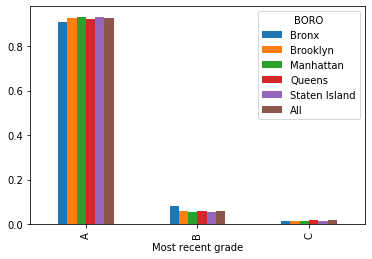

In [36]:
# It is not a significant number so we chose not to correct it
boro_grade.drop('0', axis=1).plot.bar()
plt.xlabel('Most recent grade')
plt.show()

we can ignore boro 0 as only 14 restaurants are impacted

we can see that **accross all boroughs, A grades represent 93%**. All the boroughs are very close to this number
with **Bronx being slightly lower.**


**Overall there is no obvious concentration by borough**



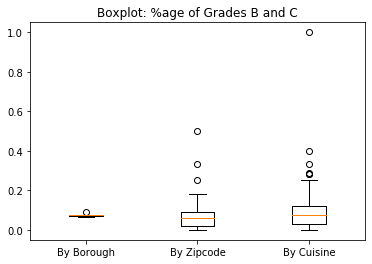

In [37]:
# lets look at the proportion for the other features for %age of grades B and C
boro_grade = boro_grade.T
boro_grade['B and C'] = boro_grade['B']+boro_grade['C']
zip_grade = zip_grade.T
zip_grade['B and C'] = zip_grade['B']+zip_grade['C']
cuisine_grade = cuisine_grade.T
cuisine_grade['B and C'] = cuisine_grade['B']+cuisine_grade['C']
cuisine_grade['B and C']


plt.boxplot(x=[boro_grade['B and C'], zip_grade['B and C'],
               cuisine_grade['B and C']], labels=['By Borough', 'By Zipcode', 'By Cuisine'])
plt.title('Boxplot: %age of Grades B and C')
plt.show()

We can see above that although there is not much difference in the proportion of most recent grades B or C between borough, this is not the case for zipcodes and type of cuisine  

In [38]:
zip_grade['B and C'].describe()

count    227.000000
mean       0.063373
std        0.057530
min        0.000000
25%        0.019615
50%        0.061069
75%        0.090332
max        0.500000
Name: B and C, dtype: float64

In [39]:
cuisine_grade['B and C'].describe()

count    85.000000
mean      0.098071
std       0.127198
min       0.000000
25%       0.029851
50%       0.076923
75%       0.120000
max       1.000000
Name: B and C, dtype: float64

**Type of Cuisine shows the greatest dispersion in terms of %age of grades B or C**. However, some cuisine descriptions are not always consistent ex: 'Pizza' is not the same than 'Pizza/Italian'

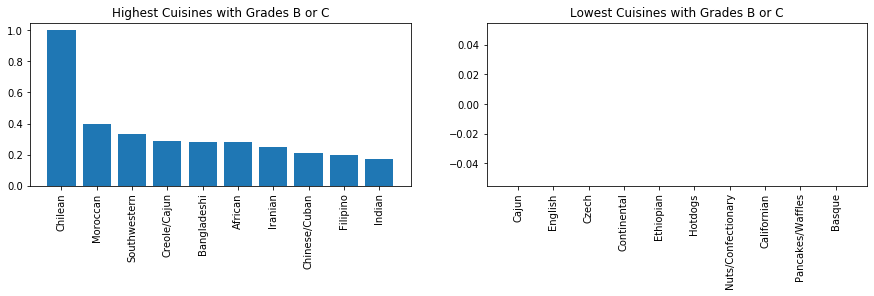

In [40]:
# top 10 cuisine vizualization
fig = plt.figure(figsize=(15, 3))

ax = fig.add_subplot(1, 2, 1)
plt.bar(x=cuisine_grade['B and C'].sort_values(ascending=False)[:10].index,
        height=cuisine_grade['B and C'].sort_values(ascending=False)[:10],)
plt.xticks(rotation=90)
plt.title('Highest Cuisines with Grades B or C')


ax = fig.add_subplot(1, 2, 2)
plt.bar(x=cuisine_grade['B and C'].sort_values(ascending=True)[:10].index,
        height=cuisine_grade['B and C'].sort_values(ascending=True)[:10],)
plt.xticks(rotation=90)
plt.title('Lowest Cuisines with Grades B or C')
plt.show()

In [41]:
# the 100% for Chilean looks, strange. Let's check how many restaurants there are in this top 10
df.groupby(by='CUISINE DESCRIPTION')['CAMIS'].count(
).loc[cuisine_grade['B and C'].sort_values(ascending=False)[:10].index]

CUISINE DESCRIPTION
Chilean            1
Moroccan          10
Southwestern       3
Creole/Cajun       7
Bangladeshi       39
African           71
Iranian            4
Chinese/Cuban     19
Filipino          30
Indian           303
Name: CAMIS, dtype: int64

In [42]:
df.groupby(by='CUISINE DESCRIPTION')['CAMIS'].count(
).loc[cuisine_grade['B and C'].sort_values(ascending=True)[:10].index]

CUISINE DESCRIPTION
Cajun                  6
English               13
Czech                  4
Continental           45
Ethiopian             13
Hotdogs               27
Nuts/Confectionary    14
Californian            5
Pancakes/Waffles      18
Basque                 1
Name: CAMIS, dtype: int64

In [43]:
# Some cuisines like Chilean or Southwestern have a very small number of restaurant.
# Let's see some indicators for the number of restaurant by cuisine
df.groupby(by='CUISINE DESCRIPTION')['CAMIS'].count().describe()

count      84.000000
mean      296.035714
std       702.342886
min         1.000000
25%        17.750000
50%        69.500000
75%       304.250000
max      5625.000000
Name: CAMIS, dtype: float64

Looking at the standard deviation vs mean and median, the results above by cuisine are more meaningful for cuisines such as African, Indian.

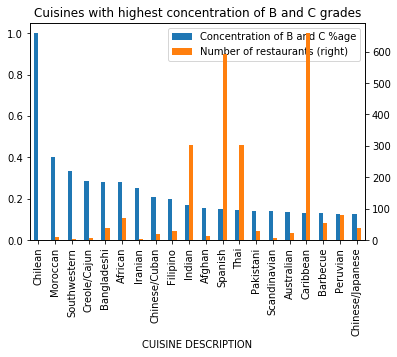

In [44]:
# let's look agains at the cuisine but this time we will also show the number of establishments
# let's merge the cuisine_grade df with the count of camis by cuisine
cuisine_grade_camisnber = pd.merge(left=cuisine_grade, right=df.groupby(
    by='CUISINE DESCRIPTION')['CAMIS'].count(), left_index=True, right_index=True)

# Let's rename the columns
cuisine_grade_camisnber.rename(mapper={
                               'B and C': 'Concentration of B and C %age', 'CAMIS': 'Number of restaurants'}, axis=1, inplace=True)

# Let's plot a bar chart with two axis
cuisine_grade_camisnber[['Concentration of B and C %age', 'Number of restaurants']].sort_values(
    by='Concentration of B and C %age', ascending=False)[0:20].plot(kind='bar', secondary_y='Number of restaurants')
plt.title('Cuisines with highest concentration of B and C grades')
plt.show()

In [45]:
# Let's look as well the number of establishment by zip codes
df.groupby(by='ZIPCODE')['CAMIS'].count().describe()

count    226.000000
mean     110.030973
std      123.651244
min        1.000000
25%       23.250000
50%       76.000000
75%      147.250000
max      647.000000
Name: CAMIS, dtype: float64

There is one zipcode with only one establishment, which is strange but there are less dispersion than for the type of cuisines.
We want to explore more the concentrations by zip codes.

In [46]:
# we want to vizualize by zipcode on a map the percentage of grades B or C
# we load the json file with zipcode data
import json
with open('zip_code_040114.geojson', 'r') as json_file:
    data_geojson = json.load(json_file)

In [47]:
# we will use the folium api
import folium

In [48]:
# we need to define a dataframe that we will pass to the choropleth map and we convert the zipcode in a string as
# in the geojson files the zipcodes are string
df_folium = zip_grade
df_folium = df_folium.reset_index()
df_folium['zip str'] = df_folium['ZIPCODE'].apply(lambda x: str(x))
df_folium['zip str'] = df_folium['zip str'].apply(
    lambda x: x.replace('.0', ''))

In [49]:
# we generate a folium map of New York City
new_york = folium.Map(location=[40.7128, -73.9352])

In [50]:
# we define the cutt-of points for the coloring scheme
quantile_zip_grade = zip_grade['B and C'].quantile(q=[0.2, 0.4, 0.6, 0.8])
max_zip_grade = zip_grade['B and C'].max()
min_zip_grade = zip_grade['B and C'].min()

In [51]:
# we use the Choropleth function
folium.Choropleth(
    geo_data=data_geojson,
    name='choropleth',
    data=df_folium,
    columns=['zip str', 'B and C'],
    key_on='feature.properties.ZIPCODE',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.7,
    threshold_scale=[min_zip_grade, quantile_zip_grade.iloc[1],
                     quantile_zip_grade.iloc[2], quantile_zip_grade.iloc[3], max_zip_grade],
    highlight=True, legend_name='Proportion of B and C Grades %').add_to(new_york)

new_york

**Recap**

1.We saw that at Borough level there is little difference in terms of A vs. non A grade repartition
2.At zipcode level this is not true anymore. We can see some red zip codes concentration (above 9.7% 80% quartile of zip codes) north of Central Park, to the East and a few north of Staten Island.
3.The type of cuisines show even greater dispersion. However, as type of cuisines do not appear to be standardized it is to be taken with caution. Moreover, some type of cuisine regroup only a very small number of establishment.

b.Time analysis

In [52]:
# we first want to retrive the month of the most recent grade
df['grade_1_month'] = df['grade_1_ts'].apply(lambda ts: ts.month)

month_grade = pd.crosstab(
    index=df['grade_1'], columns=df['grade_1_month'], normalize='columns')
month_grade

grade_1_month        1         2         3         4         5         6   \
grade_1                                                                     
A              0.916134  0.910381  0.954821  0.994121  0.987603  0.965446   
B              0.066566  0.067474  0.037087  0.002672  0.008781  0.024879   
C              0.017300  0.022145  0.008092  0.003207  0.003616  0.009675   

grade_1_month        7         8         9         10        11        12  
grade_1                                                                    
A              0.937893  0.930686  0.905575  0.862702  0.868934  0.904306  
B              0.046384  0.051144  0.075085  0.114561  0.104308  0.078469  
C              0.015723  0.018170  0.019340  0.022737  0.026757  0.017225

**we can see a decreasing trend. the peak of grade A seems to be in April with then a decreasing trend until October**

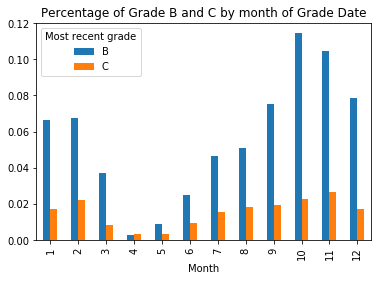

In [53]:
month_grade.T[['B', 'C']].plot.bar(
    title='Percentage of Grade B and C by month of Grade Date')
plt.legend(title='Most recent grade')
plt.xlabel('Month')
plt.show()

In [54]:
# do we have the same trend for the numbers of inspections ?
df.groupby(by='grade_1_month')['grade_1'].count()

grade_1_month
1     2659
2     2890
3     2966
4     1871
5     1936
6     1447
7     1272
8     1486
9     1758
10    2287
11    2205
12    2090
Name: grade_1, dtype: int64

There is no similar trend with the number of grades attributed by month. The trend we saw above is unlikely to be explained by the number of inspections performed by month.

c. Most recent grades vs. previous grades and inspections

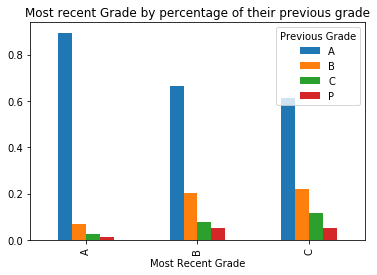

In [55]:
# lets start with the previous grades
grade_2_grade = pd.crosstab(
    index=df['grade_1'], columns=df['grade_2'], dropna=False, normalize='index')

grade_2_grade.plot.bar(
    title='Most recent Grade by percentage of their previous grade')
plt.legend(title='Previous Grade')
plt.xlabel('Most Recent Grade')
plt.show()

We see that for restaurants with most recent grade B or C, they were previously rated B, C or closed -grade P- in much higher proportion that restaurants with most recent grade A. Below we show **this proportion is actually circa. 3 times higher**

In [56]:
grade_2_grade = pd.crosstab(
    index=df['grade_1'], columns=df['grade_2'], dropna=False)
grade_2_grade.loc['B and C'] = grade_2_grade.loc['B']+grade_2_grade.loc['C']

In [57]:
grade_2_grade.drop(['B', 'C'], inplace=True)
grade_2_grade.loc['A'] = (grade_2_grade.loc['A'] /
                          grade_2_grade.loc['A'].sum())*100
grade_2_grade.loc['B and C'] = (
    grade_2_grade.loc['B and C']/grade_2_grade.loc['B and C'].sum())*100

In [58]:
grade_2_grade['B,C and P'] = grade_2_grade['B'] + \
    grade_2_grade['C']+grade_2_grade['P']

In [59]:
grade_2_grade.drop(['B', 'C', 'P'], axis=1, inplace=True)

grade_2          A  B,C and P
grade_1                      
A        89.414325  10.585675
B and C  65.504122  34.495878


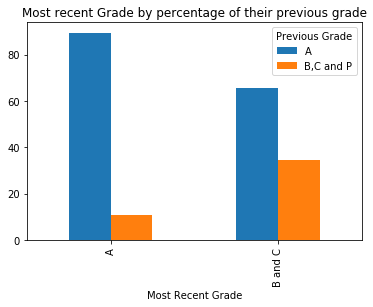

In [60]:
print(grade_2_grade)

grade_2_grade.plot.bar(
    title='Most recent Grade by percentage of their previous grade')
plt.legend(title='Previous Grade')
plt.xlabel('Most Recent Grade')
plt.show()

In [61]:
# we are also wondering what is the typical period of time between the most recent grade and the 2nd most recent one ?
df['delta_ts_grade_1_2'] = df['grade_1_ts']-df['grade_2_ts']

In [62]:
# For A grade
df[df['grade_1'] == 'A']['delta_ts_grade_1_2'].describe()

count                       20216
mean     291 days 21:13:40.577760
std      124 days 14:22:28.308143
min               1 days 00:00:00
25%             165 days 00:00:00
50%             351 days 00:00:00
75%             374 days 00:00:00
max            1071 days 00:00:00
Name: delta_ts_grade_1_2, dtype: object

In [63]:
# For B
df[df['grade_1'] == 'B']['delta_ts_grade_1_2'].describe()

count                        1256
mean     261 days 18:16:03.057324
std      148 days 14:28:32.073273
min              18 days 00:00:00
25%             156 days 00:00:00
50%             197 days 00:00:00
75%             379 days 00:00:00
max             969 days 00:00:00
Name: delta_ts_grade_1_2, dtype: object

In [64]:
# for C:
df[df['grade_1'] == 'C']['delta_ts_grade_1_2'].describe()

count                         321
mean     252 days 08:31:24.112149
std      127 days 20:08:50.086829
min              20 days 00:00:00
25%             160 days 00:00:00
50%             202 days 00:00:00
75%             364 days 00:00:00
max             825 days 00:00:00
Name: delta_ts_grade_1_2, dtype: object

In [65]:
# This makes sense that the median is close to 1 year for grade A as they have their re-inspection 11 to 13 month later
# and is shorter for B and C with a re-inspection between 3 and 7 month.

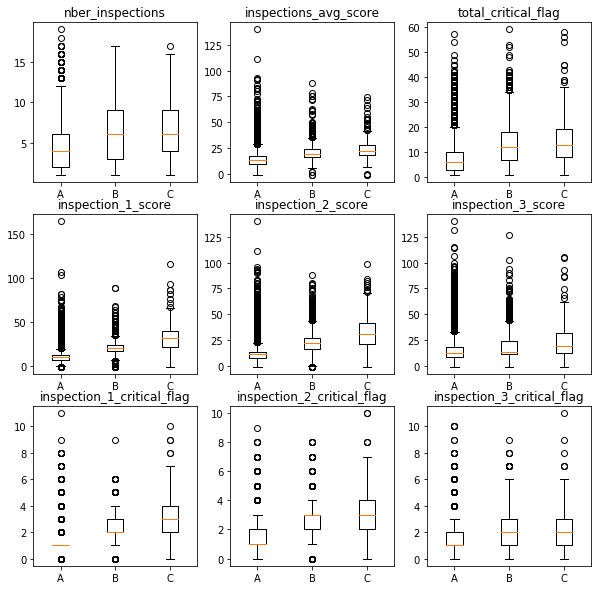

In [66]:
# lets look at inspection results

inspection_results = ['nber_inspections', 'inspections_avg_score', 'total_critical_flag',
                      'inspection_1_score', 'inspection_2_score', 'inspection_3_score',
                      'inspection_1_critical_flag', 'inspection_2_critical_flag', 'inspection_3_critical_flag']
fig = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    plt.boxplot(x=[df[df['grade_1'] == 'A'][inspection_results[i-1]].dropna(), df[df['grade_1'] == 'B'][inspection_results[i-1]].dropna(),
                   df[df['grade_1'] == 'C'][inspection_results[i-1]].dropna()], labels=['A', 'B', 'C'])
    plt.title(str(inspection_results[i-1]))

plt.show()

**Results are expected**

Total number of inspections: grade B and C get more. This is due to the fact that the inspection cycle is shorter for these grades compared to grade A

Total average score and nber of critical flag: the less good the grade, the highest the average score inspection similar for total nber of critical flags

We can then see that these trends are much pronounced if we look at the most recent inspection which is the same than the grade date --see below check-, and if we look at inspection 2. As we go further into the past with inspection 3, this trend is less pronounced.

In [67]:
sum(df['grade_1_ts'] == df['inspection_1_ts'])

22415

In [68]:
# We want to understand what are the most frequent critical violations for each grade
# We can use the original dataframe for this as we don't need to look at CAMIS level

# we filter on critical flag and group by grades
crit_violation_grade = pd.crosstab(index=data['GRADE'], columns=data[data['CRITICAL FLAG_bool'] == 1]
                                   ['VIOLATION CODE'], values=data['VIOLATION CODE'], aggfunc='count', normalize='index', margins=True)

In [69]:
crit_violation_grade

VIOLATION CODE       02A       02B       02C       02D       02E       02F  \
GRADE                                                                        
A               0.001122  0.087307  0.002457  0.000454  0.000013  0.000080   
B               0.001722  0.108580  0.002181  0.000230  0.000000  0.000230   
C               0.001889  0.089707  0.002675  0.000472  0.000000  0.000157   
G               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
N               0.002110  0.067511  0.001406  0.000703  0.000000  0.000703   
P               0.000000  0.000000  0.000000  0.001437  0.000000  0.000000   
Z               0.004032  0.086694  0.002016  0.000000  0.000000  0.002016   
All             0.001293  0.090233  0.002389  0.000425  0.000010  0.000128   

VIOLATION CODE       02G       02H       02I       03A  ...       06A  \
GRADE                                                   ...             
A               0.095504  0.023526  0.002296  0.002550  ...  0.031710   
B               0.129354  0.035638  0.002353  0.003271  ...  0.028465   
C               0.109065  0.040447  0.003777  0.005823  ...  0.027227   
G               0.000000  0.000000  0.000000  0.000000  ...  0.333333   
N               0.075246  0.023207  0.003516  0.014768  ...  0.032349   
P               0.018678  0.002874  0.000000  0.001437  ...  0.000000   
Z               0.080645  0.036290  0.000000  0.006048  ...  0.010081   
All             0.101290  0.026586  0.002389  0.003060  ...  0.030565   

VIOLATION CODE       06B       06C       06D       06E       06F       06G  \
GRADE                                                                        
A               0.014754  0.153638  0.181930  0.043834  0.041791  0.000067   
B               0.011076  0.074778  0.077704  0.027948  0.024849  0.000344   
C               0.011489  0.085615  0.064369  0.027384  0.026912  0.002675   
G               0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
N               0.014768  0.138537  0.084388  0.046414  0.021800  0.001406   
P               0.000000  0.143678  0.123563  0.008621  0.002874  0.000000   
Z               0.008065  0.092742  0.102823  0.032258  0.028226  0.002016   
All             0.013782  0.135231  0.154463  0.039805  0.037327  0.000306   

VIOLATION CODE       06H       06I       07A  
GRADE                                         
A               0.000000  0.000000  0.000000  
B               0.000000  0.000057  0.000000  
C               0.000315  0.000157  0.001416  
G               0.000000  0.000000  0.000000  
N               0.000000  0.000703  0.000000  
P               0.000000  0.000000  0.000000  
Z               0.000000  0.000000  0.000000  
All             0.000020  0.000030  0.000089  

[8 rows x 47 columns]

In [70]:
# Let's find for each grade the 5 most common critical violations, and let's see the union.
# We exclude Z, the pending grades and G -there is no explanations on what it might be in the documentation of the dataset

grade_a_top5_violations = set(
    crit_violation_grade.loc['A'].sort_values(ascending=False).index[0:5])
grade_b_top5_violations = set(
    crit_violation_grade.loc['B'].sort_values(ascending=False).index[0:5])
grade_c_top5_violations = set(
    crit_violation_grade.loc['C'].sort_values(ascending=False).index[0:5])
grade_p_top5_violations = set(
    crit_violation_grade.loc['P'].sort_values(ascending=False).index[0:5])
union = grade_a_top5_violations.union(
    grade_b_top5_violations, grade_c_top5_violations, grade_p_top5_violations)

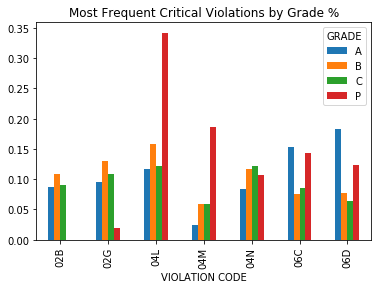

In [71]:
# Let's plot the results

crit_violation_grade.loc[['A', 'B', 'C', 'P']][sorted(union)].T.plot.bar()
plt.title('Most Frequent Critical Violations by Grade %')
plt.show()

Accross all grades, the most frequent type of critical violations are:
2B,2G,4L,6C,6D

For most recent grades A, this is the same result

For most recent grades B, and C we find the almost same list than all grades with the following exceptions:
B: 4N instead of 6C
C: 4N instead of 6D

In [72]:
data[data['VIOLATION CODE'] == '02B']['VIOLATION DESCRIPTION'].values[0]

'Hot food item not held at or above 140º F.'

In [73]:
data[data['VIOLATION CODE'] == '02G']['VIOLATION DESCRIPTION'].values[0]

'Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.'

In [74]:
data[data['VIOLATION CODE'] == '04L']['VIOLATION DESCRIPTION'].values[0]

"Evidence of mice or live mice present in facility's food and/or non-food areas."

In [75]:
data[data['VIOLATION CODE'] == '06C']['VIOLATION DESCRIPTION'].values[0]

'Food not protected from potential source of contamination during storage, preparation, transportation, display or service.'

In [76]:
data[data['VIOLATION CODE'] == '06D']['VIOLATION DESCRIPTION'].values[0]

'Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.'

In [77]:
data[data['VIOLATION CODE'] == '04N']['VIOLATION DESCRIPTION'].values[0]

'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.'

In [78]:
data[data['VIOLATION CODE'] == '04M']['VIOLATION DESCRIPTION'].values[0]

"Live roaches present in facility's food and/or non-food areas."

### 4. Data Modelling

We want to try to build a model which could predict us if the most recent grade of an establishment is A or not. We are particularly interested with the explanatory features importance.

a. Encode the data

In [79]:
# we want to predict A vs. non A so we convert grade_1 in binary variables
df['grade_1_bin'] = df['grade_1'].apply(lambda x: 0 if x == 'A' else 1)

# we treat the zipcodes and month as categorical otherwise we will not be able to convert them to dummies later
df['ZIPCODE'] = df['ZIPCODE'].astype('category')
df['grade_1_month'] = df['grade_1_month'].astype('category')


# we want to be able to use the critical violations from previous inspection as an indicator
# we first retrieve all possible critical violation codes
critical_violation_code = data[data['CRITICAL FLAG_bool']
                               == 1]['VIOLATION CODE'].unique()

# we then create binary variables for inspection 2 and 3 with each possible critical violation code.
# In the case when there was no inspection 2 or 3 we treat it the same way as if there had been
# no critical violation
for code in critical_violation_code:
    df['inspection_2_'+code] = df['inspection_2_critical_violations'].apply(
        lambda x: 0 if str(x) == 'nan' else (1 if code in x else 0))
    df['inspection_3_'+code] = df['inspection_3_critical_violations'].apply(
        lambda x: 0 if str(x) == 'nan' else (1 if code in x else 0))

In [80]:
# we encode in binary variables all categorical features: cuisine,zipcode, grade 1 month and the previous grades 2 and 3
inspection_2 = ['inspection_2_' + code for code in critical_violation_code]
inspection_3 = ['inspection_3_' + code for code in critical_violation_code]

# we know that there are missing values for grade 2 and grade 3. But as below we use dummy_na=True, it will create
# a category indicating that there is no existing grade 2 or 3.
features_dum = pd.get_dummies(
    df[['CUISINE DESCRIPTION', 'ZIPCODE', 'grade_1_month', 'grade_2', 'grade_3']+inspection_2+inspection_3], dummy_na=True)

b. Split the data

In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    features_dum, df['grade_1_bin'], test_size=0.33, random_state=42)

c. Decision Tree

First decision tree. We let it fully grow. As there are much more A than non A in the dataset, we will use balanced weight to the cost function. We could also try to undersample the grade A in the training set to create a balanced training set. However,
if we were to do that, i would be worried that we don't have a representative sample anymore as some zipcode or type of cuisines could disappear.

In [83]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [84]:
# instantiate model and fit and predict
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
tree_prediction = tree.predict(X_test)

In [85]:
# measure quality of prediction
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, precision_score, f1_score, confusion_matrix

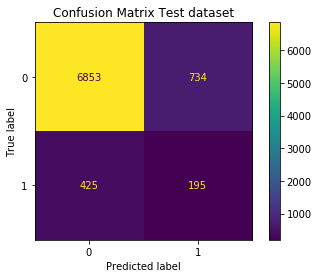

In [86]:
plot_confusion_matrix(tree, X_test, y_test, values_format='d')
plt.title('Confusion Matrix Test dataset')
plt.show()

In [87]:
accuracy_test, accuracy_train = accuracy_score(
    y_test, tree_prediction), accuracy_score(y_train, tree.predict(X_train))
recall_test, recall_train = recall_score(
    y_test, tree_prediction), recall_score(y_train, tree.predict(X_train))
precision_test, precision_train = precision_score(
    y_test, tree_prediction), precision_score(y_train, tree.predict(X_train))

print(
    f'The accuracy score on the test dataset is {accuracy_test:.1%} vs {accuracy_train:.1%} on the train dataset')
print(
    f'The recall score on the test dataser is {recall_test:.1%} vs {recall_train:.1%} on the train set')
print(
    f'The precision score on the test dataser is {precision_test:.1%} vs {precision_train:.1%} on the train set')

The accuracy score on the test dataset is 85.9% vs 100.0% on the train dataset
The recall score on the test dataser is 31.5% vs 100.0% on the train set
The precision score on the test dataser is 21.0% vs 100.0% on the train set


In [88]:
print(
    f'The tree depth is {tree.get_depth()} and it has {tree.get_n_leaves()} leaves')

The tree depth is 95 and it has 2040 leaves


### 5. Evaluate the results

**The decision tree is overfitting. As the various measures are much better for the train set vs. the test set.** We will regularize the tree using maximum depth,min_samples_split, min_samples_leaf and we will try either gini or entropy for the impurity function.

To find the best parameters we will use gridsearch.

We are not really interested by the accuracy as a model which would always predict A would reach 93% accuracy given the strong imbalance in the dataset. **We are interested in the capacity of the model to detect the non A grade (recall) and its capacity to avoid false alarms (precision)**. So we will use for the score to maximize the f1 score which is a measure summarizing the trade-off which can be achieved between recall and precision.

a. Regularizing the model

In [89]:
def tree_gridsearch(X_train, y_train):
    '''This function takes a training set of features and target, then perform a gridsearch to find the best parameters
    to maximize the f1 score.

    INPUT
    X_train- an array of training features
    y_train- an array of training targets

    OUTPUT
    best_score- float, the maximum mean score for f1 after a 5 folds cross validation.
    best_parameters- dictionnary, the parameters of the best estimator
    best_estimator- the best decision tree fitted on the whole train datasets
    df_features_imp- dataframe, listing in descending order the contribution of each features. Non contributing
    features are not listed
    search_results- dataframe, listing all the results of the gridsearchcv

    '''
    tree = DecisionTreeClassifier(class_weight='balanced')
    grid = {'max_depth': [3, 4, 5, 6, 7, None], 'min_samples_split': [
        2, 10, 20, 30, 40], 'min_samples_leaf': [10, 20, 30, 40, 50, 60], 'criterion': ['gini', 'entropy']}
    # In Gridsearch we put refit=True as in our function we pass a training set. We will then look at predictions
    # on a test set completely unused in fitting the model.
    search = GridSearchCV(estimator=tree, param_grid=grid,
                          scoring='f1', refit=True)
    search.fit(X_train, y_train)
    best_score = search.best_score_
    best_parameters = search.best_params_
    best_estimator = search.best_estimator_
    search_results = pd.DataFrame(search.cv_results_)

    # we create a dataframe which will indicate us the name of the features with an importance measure above 0
    features_imp = {'features': X_train.columns,
                    'importance': best_estimator.feature_importances_}
    df_features_imp = pd.DataFrame(features_imp)
    df_features_imp.sort_values(by='importance', ascending=False, inplace=True)
    df_features_imp = df_features_imp[df_features_imp['importance'] > 0]

    return best_score, best_parameters, best_estimator, df_features_imp, search_results

In [90]:
best_score_past, best_parameters_past, best_tree_past, features_imp_past, search_results_past = tree_gridsearch(
    X_train, y_train)

In [91]:
best_score_past

0.29719025283014594

In [92]:
best_parameters_past

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 20,
 'min_samples_split': 30}

In [93]:
# We want a model that we can interpret. So we will order the models according to their performance
# and the depth of the tree. We would prefer a model slightly less good in terms of performance but less deep
# so it can be easier to understand

search_results_past.groupby(by='param_max_depth')['mean_test_score'].max()

param_max_depth
3    0.233948
4    0.268764
5    0.268378
6    0.282341
7    0.294264
Name: mean_test_score, dtype: float64

In [94]:
# What is the standard deviation of f1 score for the best tree ?
search_results_past[search_results_past['rank_test_score']
                    == 1]['std_test_score']

158    0.00991
Name: std_test_score, dtype: float64

In [95]:
# let's look at the parameters for max_depth=7 as the results are less than from one standard deviation of the best model
max_rank_depth = search_results_past[search_results_past['param_max_depth']
                                     == 7]['rank_test_score'].max()

search_results_past[(search_results_past['param_max_depth'] == 7) & (
    search_results_past['rank_test_score'] == max_rank_depth)]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
135       0.313085      0.029677         0.015675        0.000126   
136       0.287256      0.005804         0.009366        0.007647   
137       0.286318      0.006291         0.015623        0.000002   
138       0.287529      0.007589         0.009372        0.007652   
139       0.290617      0.007581         0.012501        0.006251   

    param_criterion param_max_depth param_min_samples_leaf  \
135            gini               7                     40   
136            gini               7                     40   
137            gini               7                     40   
138            gini               7                     40   
139            gini               7                     40   

    param_min_samples_split  \
135                       2   
136                      10   
137                      20   
138                      30   
139                      40   

                                                params  split0_test_score  \
135  {'criterion': 'gini', 'max_depth': 7, 'min_sam...           0.270748   
136  {'criterion': 'gini', 'max_depth': 7, 'min_sam...           0.270748   
137  {'criterion': 'gini', 'max_depth': 7, 'min_sam...           0.270748   
138  {'criterion': 'gini', 'max_depth': 7, 'min_sam...           0.270748   
139  {'criterion': 'gini', 'max_depth': 7, 'min_sam...           0.270748   

     split1_test_score  split2_test_score  split3_test_score  \
135           0.270531           0.289941           0.287747   
136           0.270531           0.289941           0.287747   
137           0.270531           0.289941           0.287747   
138           0.270531           0.289941           0.287747   
139           0.270531           0.289941           0.287747   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
135           0.287188         0.281231        0.008697              133  
136           0.287188         0.281231        0.008697              133  
137           0.287188         0.281231        0.008697              133  
138           0.287188         0.281231        0.008697              133  
139           0.287188         0.281231        0.008697              133

In [96]:
# We will select the most constrained and fit it to the train data set

best_simple_tree_past = DecisionTreeClassifier(
    class_weight='balanced', criterion='gini', max_depth=7, min_samples_leaf=40, min_samples_split=40)
best_simple_tree_past.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

b. Understand and interpret the results

In [97]:
# we create a dataframe which will indicate us the name of the features with an importance measure above 0
features_imp = {'features': X_train.columns,
                'importance': best_simple_tree_past.feature_importances_}
df_features_imp = pd.DataFrame(features_imp)
df_features_imp.sort_values(by='importance', ascending=False, inplace=True)
df_features_imp = df_features_imp[df_features_imp['importance'] > 0]

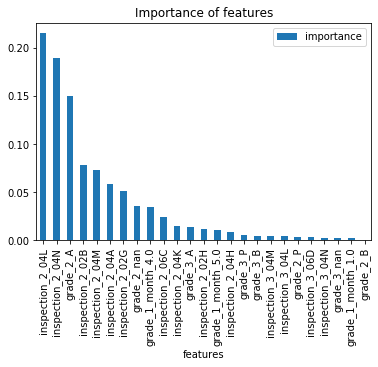

In [98]:
df_features_imp.plot.bar(x='features')
plt.title('Importance of features')
plt.show()

In [99]:
# What are inspection violations 04A, 04K, 02H and 04H which we did not see in the data exploration phase ?
print(data[data['VIOLATION CODE'] == '04A']['VIOLATION DESCRIPTION'].values[0])
print('\n')
print(data[data['VIOLATION CODE'] == '04K']['VIOLATION DESCRIPTION'].values[0])
print('\n')
print(data[data['VIOLATION CODE'] == '02H']['VIOLATION DESCRIPTION'].values[0])
print('\n')
print(data[data['VIOLATION CODE'] == '04H']['VIOLATION DESCRIPTION'].values[0])

Food Protection Certificate not held by supervisor of food operations.


Evidence of rats or live rats present in facility's food and/or non-food areas.


Food not cooled by an approved method whereby the internal product temperature is reduced from 140º F to 70º F or less within 2 hours, and from 70º F to 41º F or less within 4 additional hours.


Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.


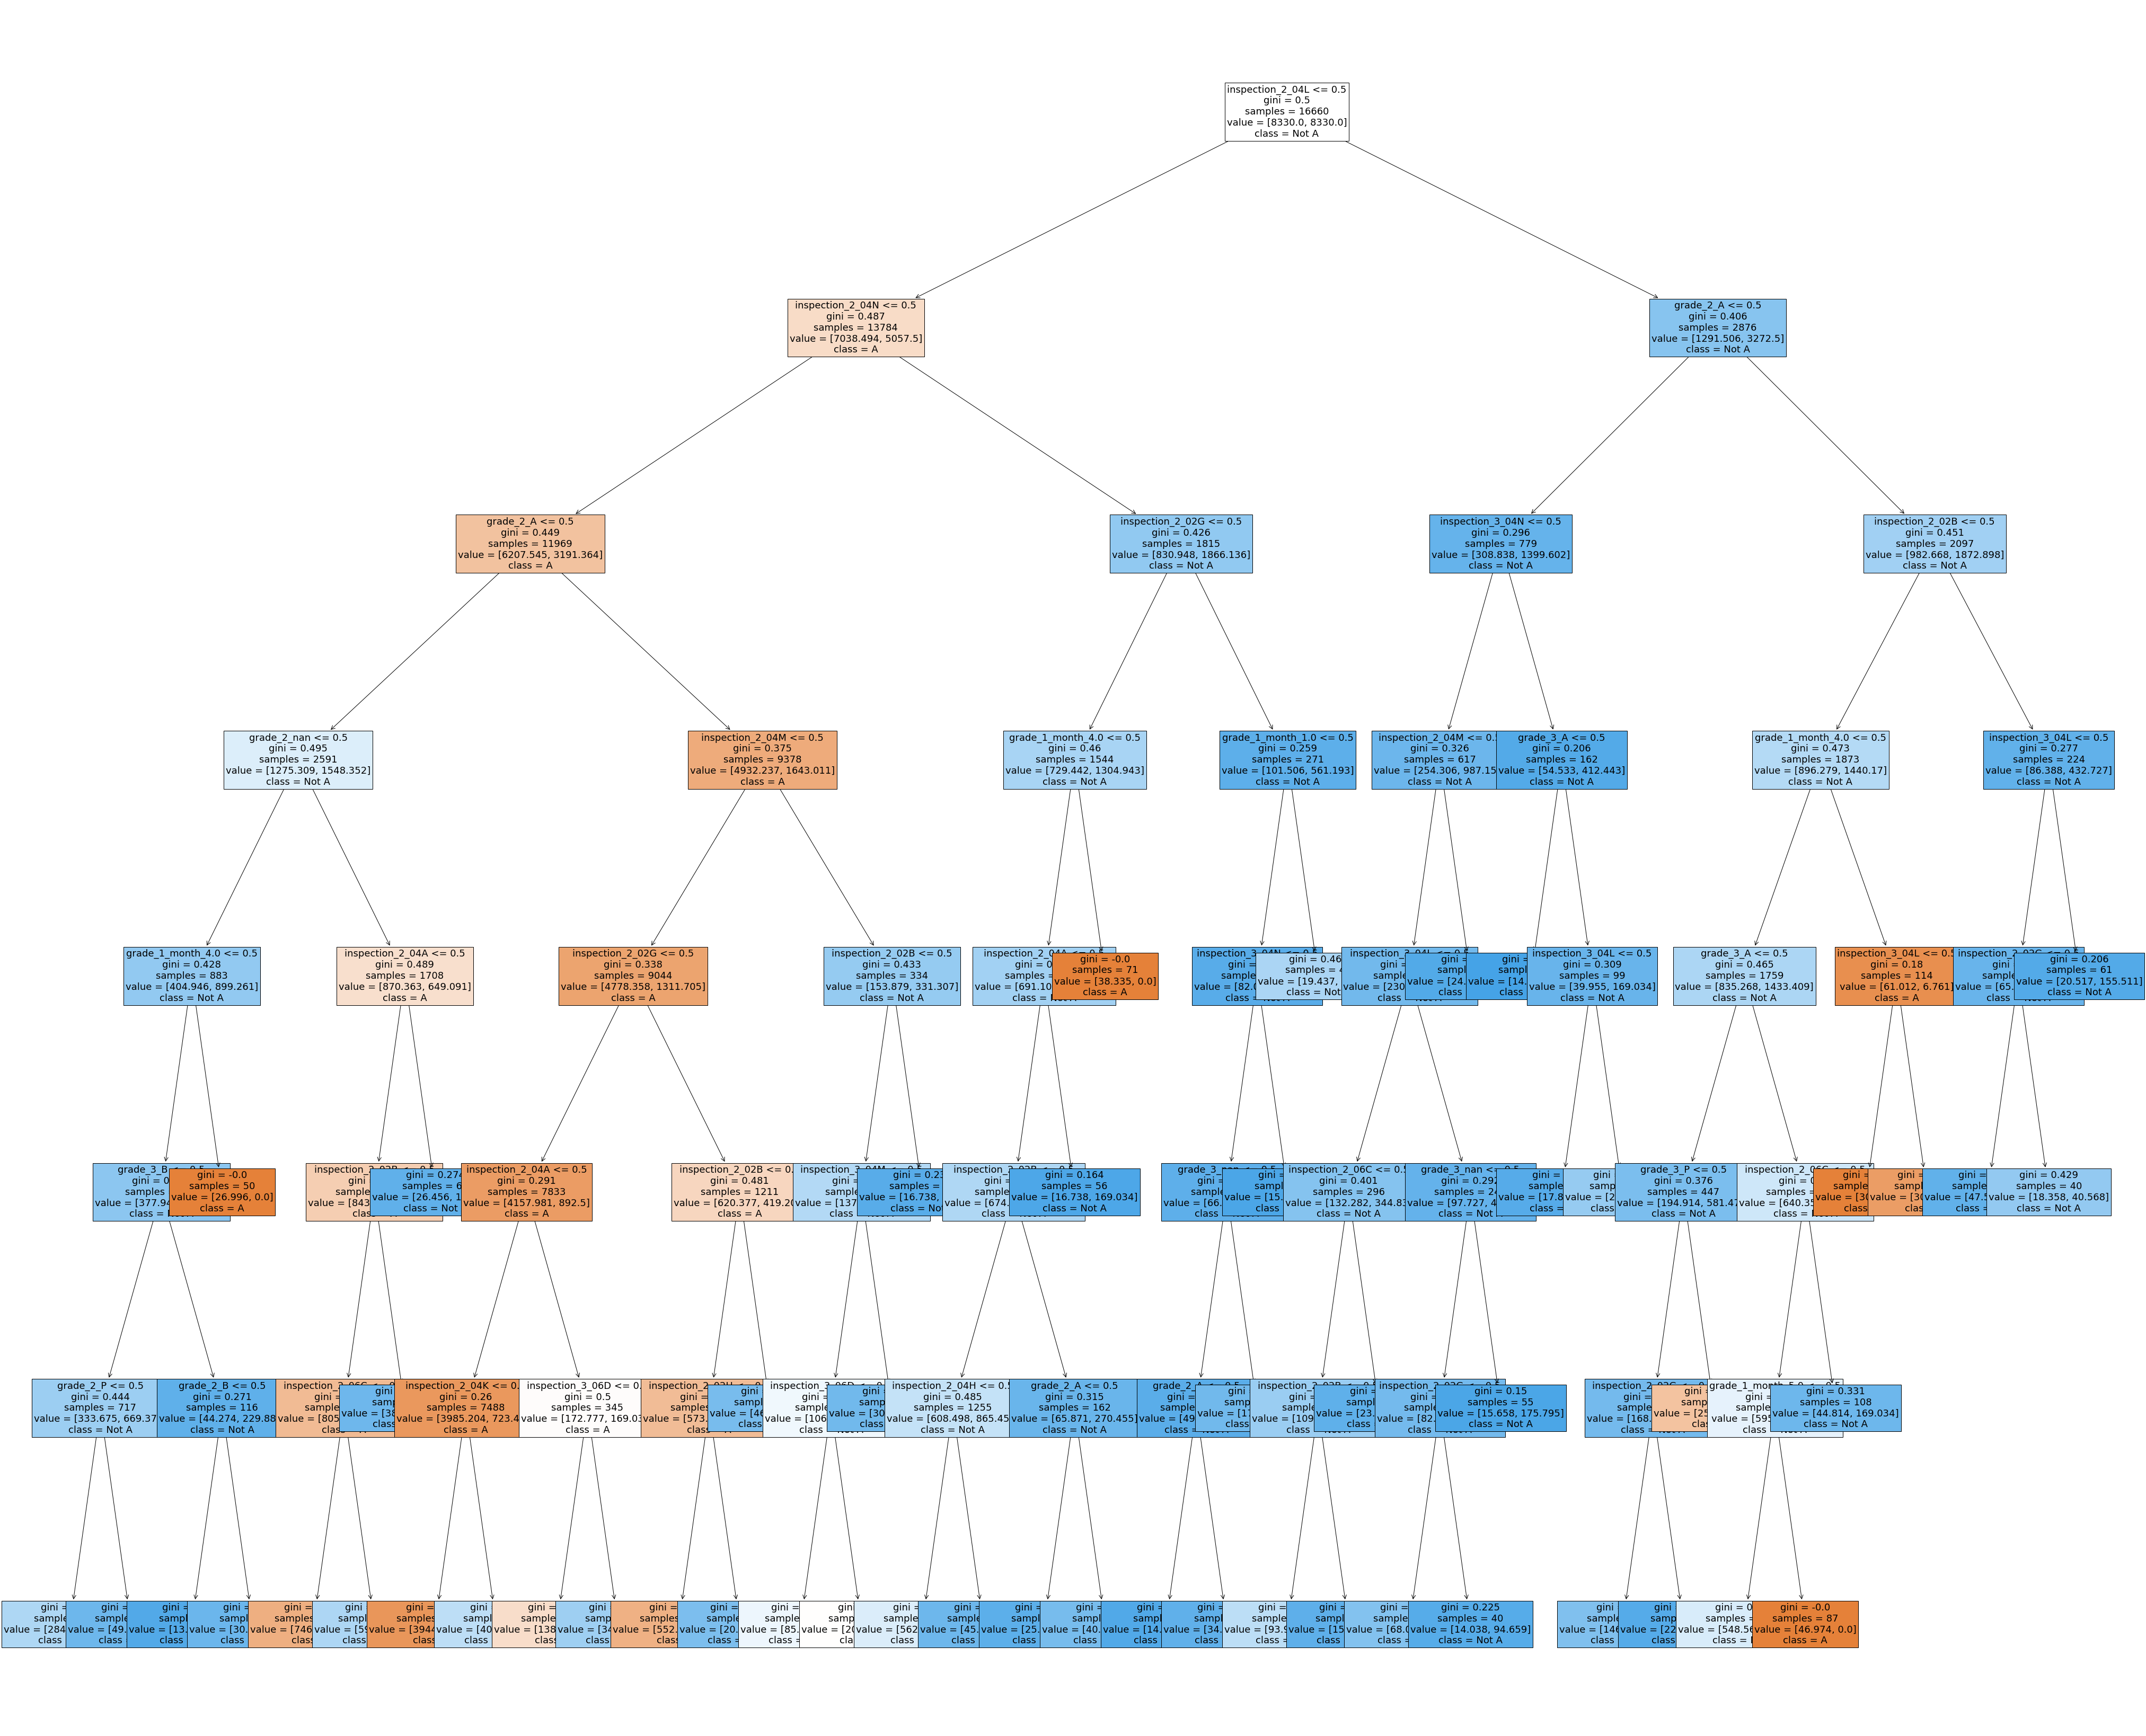

In [100]:
plt.figure(figsize=(70, 60))
plot_tree(best_simple_tree_past, filled=True, class_names=[
          'A', 'Not A'], feature_names=X_train.columns, fontsize=18)
plt.show()

Looking at the decision tree and the bar plot with the features importance, we can make the following observations:
**By far the most important features are the previous critical violations detected, the previous grades and whether the month of the grade we are trying to predict is April or not**. 

**Type of cuisine and location play no role.**

**If the inspection just before the most recent grade detected mice, most of the predictions for the future grade will be not  A**. The exceptions are very few to this prediction rule.

**If the inspection just before the most recent grade did NOT detect mice, most of the predictions for the future grade will be an A**. But there are more exceptions, the main ones being:

1. If the inspection just before the most recent grade detected flies, almost all of the predictions will be not A.
2. If the inspection just before the most recent grade did not detect flies but did detect roaches and the previous grade was A, then most of the predictions will be not A.
3. If the inspection just before the most recent grade did not detect flies, there was a previous grade available but not an A and the month of the grade we are trying to predict is not April, then the predictions will be not A.


c. Fine tune the model

In [101]:
# we want to fine tune the model by changing the threshold of the probability. By default it is 0.5.
# we want to see if we could improve the recall by lowering it without deteriorating too much the precision


def recall_threshold(X, y, tree, threshold):
    '''This function takes a feature and a target dataset, a fitted tree and a probability threshold for the decision.
    It returns the recall score on predictions on the set using this threshold instead of the default 0.5

    INPUT
    X,y: array- the features and targets datasets
    tree: a fitted decision tree
    threshold: float between 0 and 1, the probability we want to use

    OUTPUT
    recall- float, the recall score on the dataset prediction using the threshold 
    '''
    predictions_train = (tree.predict_proba(X)[:, 1] > threshold).astype(bool)
    recall = recall_score(y, predictions_train)
    return recall


def precision_threshold(X, y, tree, threshold):
    '''This function takes a feature and a target dataset, a fitted tree and a probability threshold for the decision.
    It returns the precision score on predictions on the set using this threshold instead of the default 0.5

    INPUT
    X,y: array- the features and targets datasets
    tree: a fitted decision tree
    threshold: float between 0 and 1, the probability we want to use

    OUTPUT
    precision- float, the precision score on the dataset prediction using the threshold 
    '''
    predictions_train = (tree.predict_proba(X)[:, 1] > threshold).astype(bool)
    precision = precision_score(y, predictions_train, zero_division=0)
    return precision


def accuracy_threshold(X, y, tree, threshold):
    '''This function takes a feature and a target dataset, a fitted tree and a probability threshold for the decision.
    It returns the accuracy score on predictions on the set using this threshold instead of the default 0.5

    INPUT
    X,y: array- the features and targets datasets
    tree: a fitted decision tree
    threshold: float between 0 and 1, the probability we want to use

    OUTPUT
    accuracy- float, the accuracy score on the dataset prediction using the threshold 
    '''
    predictions_train = (tree.predict_proba(X)[:, 1] > threshold).astype(bool)
    accuracy = accuracy_score(y, predictions_train)
    return accuracy

In [102]:
# We compute on train and test datasets the precision,recall and accuracy for various threshold of probability

x = np.linspace(0, 1, 200)
recall_train = np.array(
    [recall_threshold(X_train, y_train, best_simple_tree_past, z) for z in x])
precision_train = np.array([precision_threshold(
    X_train, y_train, best_simple_tree_past, z) for z in x])
accuracy_train = np.array(
    [accuracy_threshold(X_train, y_train, best_simple_tree_past, z) for z in x])

recall_test = np.array(
    [recall_threshold(X_test, y_test, best_simple_tree_past, z) for z in x])
precision_test = np.array([precision_threshold(
    X_test, y_test, best_simple_tree_past, z) for z in x])
accuracy_test = np.array(
    [accuracy_threshold(X_test, y_test, best_simple_tree_past, z) for z in x])

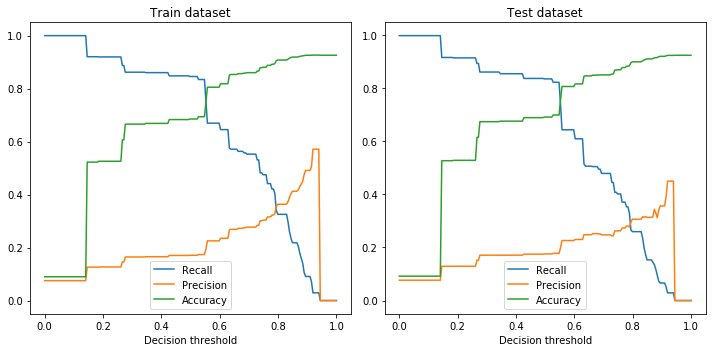

In [103]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
plt.plot(x, recall_train, label='Recall')
plt.plot(x, precision_train, label='Precision')
plt.plot(x, accuracy_train, label='Accuracy')
plt.title('Train dataset')
plt.xlabel('Decision threshold')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
plt.plot(x, recall_test, label='Recall')
plt.plot(x, precision_test, label='Precision')
plt.plot(x, accuracy_test, label='Accuracy')
plt.title('Test dataset')
plt.xlabel('Decision threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
# If we are particularly risk adverse we want a high recall. let's set the threshold at 0.4
confusion_matrix(y_test, (best_simple_tree_past.predict_proba(
    X_test)[:, 1] > 0.4).astype(bool))

array([[1497,  804],
       [  26,  159]], dtype=int64)

In [112]:
# let's check recall and accuracy on the test set with this new threshold
accuracy_test = accuracy_score(y_test, (best_simple_tree_past.predict_proba(
    X_test)[:, 1] > 0.4).astype(bool))

recall_test = recall_score(y_test, (best_simple_tree_past.predict_proba(
    X_test)[:, 1] > 0.4).astype(bool))

print(f'The accuracy score on the test dataset is {accuracy_test}')
print(f'The recall score on the test dataset is {recall_test}')

The accuracy score on the test dataset is 0.666130329847144
The recall score on the test dataset is 0.8594594594594595


In [106]:
# we want to make sure that these results will generalize well.
# we perform a 10 folds cross validation with the parameters of the best model
# and loop through probability thresholds

skf = StratifiedKFold(n_splits=10, shuffle=True)

accuracy_test_mean = []
accuracy_test_std = []
recall_test_mean = []
recall_test_std = []

for threshold in np.linspace(0, 1, 200):

    accuracy_test_10f = []
    recall_test_10f = []

    for train_index, test_index in skf.split(features_dum.to_numpy(), df['grade_1_bin'].to_numpy()):
        # We select the train and test datasets
        X_train = features_dum.to_numpy()[train_index]
        y_train = df['grade_1_bin'].to_numpy()[train_index]
        X_test = features_dum.to_numpy()[test_index]
        y_test = df['grade_1_bin'].to_numpy()[test_index]

        # We fit our best simpler tree
        best_simple_tree_past.fit(X_train, y_train)

        # We compute our metrics with the threshold
        accuracy_test_fold = accuracy_score(
            y_test, (best_simple_tree_past.predict_proba(X_test)[:, 1] > threshold).astype(bool))
        accuracy_test_10f.append(accuracy_test_fold)

        recall_test_fold = recall_score(
            y_test, (best_simple_tree_past.predict_proba(X_test)[:, 1] > threshold).astype(bool))
        recall_test_10f.append(recall_test_fold)

    # we compute the mean and std for a given threshold accross the 10 folds
    recall_test_mean.append(statistics.mean(recall_test_10f))
    accuracy_test_mean.append(statistics.mean(accuracy_test_10f))
    recall_test_std.append(statistics.stdev(recall_test_10f))
    accuracy_test_std.append(statistics.stdev(accuracy_test_10f))

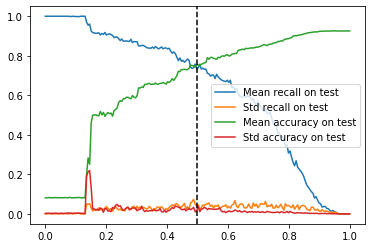

In [107]:
# Let's plot the results

plt.plot(np.linspace(0, 1, 200), recall_test_mean, label='Mean recall on test')
plt.plot(np.linspace(0, 1, 200), recall_test_std, label='Std recall on test')
plt.plot(np.linspace(0, 1, 200), accuracy_test_mean,
         label='Mean accuracy on test')
plt.plot(np.linspace(0, 1, 200), accuracy_test_std,
         label='Std accuracy on test')
plt.axvline(x=0.5, ls='--', color='black')
plt.legend()
plt.show()

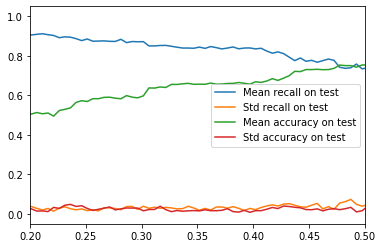

In [108]:
# let's zoom on the part before probability at 0.5

plt.plot(np.linspace(0, 1, 200), recall_test_mean, label='Mean recall on test')
plt.plot(np.linspace(0, 1, 200), recall_test_std, label='Std recall on test')
plt.plot(np.linspace(0, 1, 200), accuracy_test_mean,
         label='Mean accuracy on test')
plt.plot(np.linspace(0, 1, 200), accuracy_test_std,
         label='Std accuracy on test')
plt.legend()
plt.xlim((0.2, 0.5))
plt.show()

We can see that the standard deviations accross the 10 folds on both recall and accuracy are stable and low. This is an indication that results should generalize well.

Depending of how conservative we are, we could choose a higher recall for less accuracy. I will keep 0.4 to have a recall at 86%.

### Conclusion

This informal study showed that **the location or type of cuisine of an establishment dit not matter** when trying to calibrate a useful model for health grade prediction, with a high recall in order to be conservative in choices.

**The model used detects well the non A grade establishments**. It relies mostly on past inspection results as well as past grades, which are very specific information about each establishment. 

To go further various other models could be explored, and numerous features could be added: average cost in each establishments, reviews, sanitation complaints in the vicinity of establishments…etc

This last feature could be very useful as the past critical violations which matter the most are all related to vermin. 